<a href="https://colab.research.google.com/github/Oscar8gonzalez8/MachineLearning/blob/main/Module_3_preprossesed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import plotnine as p9
from plotnine import ggplot, aes, geom_point, geom_smooth, geom_histogram, labs
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import math
import numpy as np

In [ ]:

dat = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')

dat.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price'],
      dtype='object')

In [ ]:
#Load medina income
df2 = pd.read_csv("https://raw.githubusercontent.com/Archarlie2000/CS450-Team/main/income.csv", error_bad_lines=False)


#Treating data
dat['date'] = dat['date'].str[:8]
df2['NAME'] = df2['NAME'].str[5:]
df2['NAME'] = df2['NAME'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)
df2.rename(columns = {'NAME':'zipcode'}, inplace = True)
df2.rename(columns = {'S1901_C01_012E':'median_income'}, inplace = True)

#Merge data back in
df3 = pd.merge(dat, df2, on = "zipcode", how = "left")
df4 = df3
df3.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.




,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,median_income
0,1565930130,20141104,4,3.25,3760,4675,2.0,0,0,3,...,1020,2007,0,98038,47.3862,-122.048,3280,4033,429900.0,114804
1,3279000420,20150115,3,1.75,1460,7800,1.0,0,0,2,...,420,1979,0,98023,47.3035,-122.382,1310,7865,233000.0,82566
2,194000575,20141014,4,1.00,1340,5800,1.5,0,2,3,...,0,1914,0,98116,47.5658,-122.389,1900,5800,455000.0,121967
3,2115510160,20141208,3,1.75,1440,8050,1.0,0,0,3,...,0,1985,0,98023,47.3187,-122.390,1790,7488,258950.0,82566
4,7522500005,20140815,2,1.50,1780,4750,1.0,0,0,4,...,700,1947,0,98117,47.6859,-122.395,1690,5962,555000.0,131508


In [ ]:
from numpy import log10
#Normalize 
# Square living
# Square lot
# Add basement category
# square lot of average 15 nearest homes


#Add zscore column to normalize the data
df3['norm_sq_liv']= stats.zscore(df3['sqft_living'])
df3['norm_sq_lot']=stats.zscore(df3['sqft_lot'])
df3['has_bsmnt'] = df3['sqft_basement'].apply(lambda x: 1 if x>0 else 0)
df3['norm_lot15']=stats.zscore(df3['sqft_lot15'])
df3['norm_price']= log10(df3['price'])

#Change Median income to int dtype
df3['median_income']=df3['median_income'].astype(int)

#Change date dtype, convert to string then concat month and year
df3['date']= pd.to_datetime(df3['date'])
df3['year']= pd.DatetimeIndex(df3['date']).year.astype(str)
df3['month'] = pd.DatetimeIndex(df3['date']).month.astype(str)
df3['year_month']= df3['year']+df3['month']
df3 = df3.drop(df3.filter(['year', 'month']).columns, axis=1)

#One hot encode the data
one_hot = pd.get_dummies(data=df3, columns = ['zipcode', 'year_month', 'condition', 'grade'], drop_first=True)

In [ ]:
X = one_hot.drop(one_hot.filter(['id', 'lat', 'long', 'price', 'norm_price', 'sqft_living', 'sqft_lot', 'date', 'has_bsmnt', 'norm_lot15']).columns, axis=1)
y = one_hot.norm_price

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, random_state = 5
)


X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=.3, random_state = 5
)



In [ ]:
#Single Model
model = XGBRegressor(objective = 'reg:squarederror', min_child_weight = 15, max_depth = 6, n_estimators = 400, learning_rate = 0.1)
model.fit(X_train, y_train)
pred_val = model.predict(X_val)


In [ ]:
print('r_squared: ', r2_score(y_true = y_val, y_pred = pred_val))
print('RMSE: ', ((math.sqrt(mean_squared_error(y_true = 10**y_val, y_pred = 10**pred_val)))))


r_squared:  0.8825978554303532
RMSE:  122256.82721678657


In [ ]:
df6 = {'true': y_val, 'predict': pred_val}

{'true': 16392    5.848189
 7949     5.763428
 11994    5.924279
 6360     5.591065
 10539    5.726972
            ...   
 10098    5.574031
 15407    5.662758
 10400    5.698970
 10125    5.740363
 9593     5.732394
 Name: norm_price, Length: 4800, dtype: float64,
 'predict': array([5.8235793, 5.7028556, 5.870684 , ..., 5.845596 , 5.9149957,
        5.7995   ], dtype=float32)}

In [ ]:
result = pd.DataFrame({'learning_rate': [],
                    'subsample' : []})


sns.scatterplot(x = "pred_val", y = "y_val")

ValueError: ignored

In [ ]:
#Not modified model
model = XGBRegressor(objective = 'reg:squarederror')
model.fit(X_train, y_train)
pred_val = model.predict(X_val)
print('r_squared: ', r2_score(y_true = y_val, y_pred = pred_val))
print('RMSE: ', ((math.sqrt(mean_squared_error(y_true = 10**y_val, y_pred = 10**pred_val)))))

r_squared:  0.8139923609366111
RMSE:  153764.61731412914


# untreated data


In [ ]:
df5 = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')

df5['date'] = df5['date'].str[:7]
df5['date'] = pd.to_numeric(df5['date'])

X = df5.loc[:, df5.columns != 'price'] 
y = df5["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .15, random_state = 35)

modeluno = XGBRegressor(objective = 'reg:squarederror')
modeluno.fit(X_train, y_train)
pred_val = modeluno.predict(X_test)
print('r_squared: ', r2_score(y_true = y_test, y_pred = pred_val))
print('RMSE: ', ((math.sqrt(mean_squared_error(y_true = y_test, y_pred = pred_val)))))




r_squared:  0.8520258047761344
RMSE:  135603.87927313193


In [ ]:
model = XGBRegressor(objective = 'reg:squarederror', min_child_weight = 15, max_depth = 6, n_estimators = 400, learning_rate = 0.1)
model.fit(X_train, y_train)
pred_val = model.predict(X_test)
print('r_squared: ', r2_score(y_true = y_test, y_pred = pred_val))
print('RMSE: ', ((math.sqrt(mean_squared_error(y_true = y_test, y_pred = pred_val)))))


r_squared:  0.8809330122072735
RMSE:  121639.54971296708


# Grid Search Model

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import math
import numpy as np
from sklearn.metrics import mean_squared_error



In [ ]:
# Use this as a tuning values template
PARAMETERS = {"subsample":[0.5],
              "max_depth":[4, 6],
              "min_child_weight":[10, 15],
              "learning_rate":[0.1, 0.15],
              "n_estimators":[350, 400]}

In [ ]:
# Beta
result = pd.DataFrame({'learning_rate': [],
                    'subsample' : [],
                    'max_depth' : [],
                    'n_estimators' : [],
                    'min_child_weight' : [],
                    'R2' : []})

for subsample in PARAMETERS["subsample"]:
  for n_estimators in PARAMETERS["n_estimators"]:
    for min_child_weight in PARAMETERS["min_child_weight"]:
      for max_depth in PARAMETERS["max_depth"]:
        for learning_rate in PARAMETERS["learning_rate"]:
          model = XGBRegressor(objective = 'reg:squarederror', 
                               min_child_weight = min_child_weight, 
                               max_depth = max_depth, 
                               n_estimators = n_estimators, 
                               learning_rate = learning_rate)
          
          model.fit(X_train, y_train)
      
          new_row = {'learning_rate': learning_rate ,
                    'subsample': subsample, 
                    'max_depth': max_depth, 
                    "min_child_weight" : min_child_weight, 
                    'n_estimators': n_estimators, 
                    'R2': model.score(X_val, y_val)}
                  
          result = result.append(new_row, ignore_index = True)
          print("Learning rate: ", learning_rate)
          print("max_depth: ", max_depth)
          print("subsample: ", subsample)
          print("min_child_weight: ", min_child_weight)
          print("n_estimator: ", n_estimators)
          print("r2 (training): ", model.score(X_val, y_val))
          print("-----------------------------------------------")



Learning rate:  0.1
max_depth:  4
subsample:  0.5
min_child_weight:  10
n_estimator:  350
r2 (training):  0.874469007674068
-----------------------------------------------
Learning rate:  0.15
max_depth:  4
subsample:  0.5
min_child_weight:  10
n_estimator:  350
r2 (training):  0.8801924732652866
-----------------------------------------------
Learning rate:  0.1
max_depth:  6
subsample:  0.5
min_child_weight:  10
n_estimator:  350
r2 (training):  0.8802074139946026
-----------------------------------------------
Learning rate:  0.15
max_depth:  6
subsample:  0.5
min_child_weight:  10
n_estimator:  350
r2 (training):  0.8790085787308912
-----------------------------------------------
Learning rate:  0.1
max_depth:  4
subsample:  0.5
min_child_weight:  15
n_estimator:  350
r2 (training):  0.8752516444793146
-----------------------------------------------
Learning rate:  0.15
max_depth:  4
subsample:  0.5
min_child_weight:  15
n_estimator:  350
r2 (training):  0.8795873783351462
--------

# Grid Search Result

In [ ]:
# Raw data
result

,learning_rate,subsample,max_depth,n_estimators,min_child_weight,R2
0,0.10,0.5,4.0,350.0,10.0,0.874469
1,0.15,0.5,4.0,350.0,10.0,0.880192
2,0.10,0.5,6.0,350.0,10.0,0.880207
3,0.15,0.5,6.0,350.0,10.0,0.879009
4,0.10,0.5,4.0,350.0,15.0,0.875252
5,0.15,0.5,4.0,350.0,15.0,0.879587
6,0.10,0.5,6.0,350.0,15.0,0.881744
7,0.15,0.5,6.0,350.0,15.0,0.879952
8,0.10,0.5,4.0,400.0,10.0,0.876814
9,0.15,0.5,4.0,400.0,10.0,0.881311


In [ ]:
# Downlaod Files
from google.colab import files

result.to_csv('output.csv', encoding = 'utf-8-sig') 
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

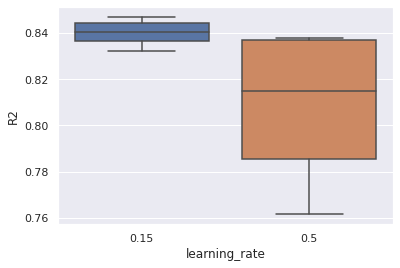

In [ ]:
sns.boxplot(data = result, x = "learning_rate", y = "R2")

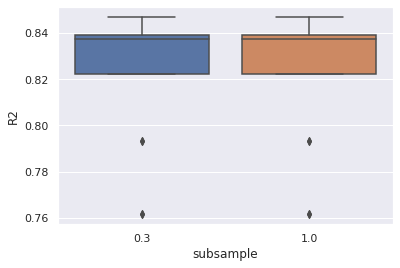

In [ ]:
sns.boxplot(data = result, x = "subsample", y = "R2")

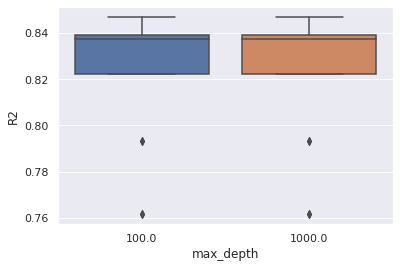

In [ ]:
sns.boxplot(data = result, x = "max_depth", y = "R2")

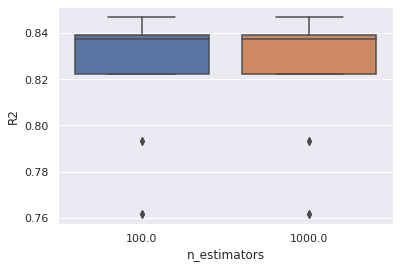

In [ ]:
sns.boxplot(data = result, x = "n_estimators", y = "R2")

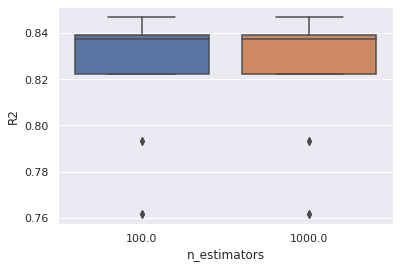

In [ ]:
sns.boxplot(data = result, x = "n_estimators", y = "R2")

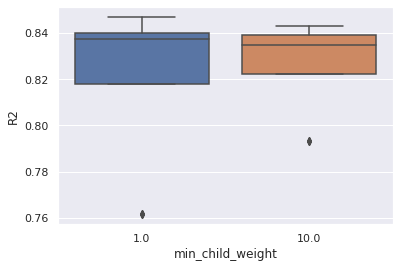

In [ ]:
sns.boxplot(data = result, x = "min_child_weight", y = "R2")


# Making graphs

In [ ]:
sns.scatterplot(data = df3, y = 'price', x = 'median_income').set(title = 'Relationship between Median_income and Price'


SyntaxError: ignored

In [ ]:
import altair as alt


alt.Chart(df4).mark_circle(size = 60).encode(
    x = 'median_income',
    y = 'price',
    color = 'Origin',
    tooltip=['Name', 'Origin', 'Horsepower', 'Miles_per_Gallon']
).interactive()

MaxRowsError: ignored

alt.Chart(...)